# Setup

In [403]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

import torchvision

import os
import numpy as np
import matplotlib.pyplot as plt

In [404]:
# define utility functions

def apply_field(img, field):
    # create identity coordinate grid
    grid = torch.stack(torch.meshgrid(torch.arange(28), torch.arange(28)), dim=-1).float()
    grid = grid.unsqueeze(0)  # Add batch dimension
    grid = grid.repeat(img_sub.shape[0], 1, 1, 1)
    grid = (grid / 28) * 2 - 1
    
    # add field to grid
    field = field.permute(0,2,3,1)
    coords_adj = grid + field
    coords_adj = coords_adj.float().permute(0,2,1,3)

    # adjust image
    img_adj = F.grid_sample(img, coords_adj, mode="bilinear", align_corners=True)
    
    return(img_adj)

def loss(img1, img2, field, lmbda):
    """Calculates loss associated with image reconstruction and associated field."""
    
    # approximate field gradient
    diff_x = torch.diff(field[:,:,:,0], axis=1)
    diff_y = torch.diff(field[:,:,:,1], axis=2)
    diff_x = F.pad(diff_x, (0, 0, 1, 0), mode='constant')
    diff_y = F.pad(diff_y, (1, 0, 0, 0), mode='constant')

    # calculate loss
    loss_sim = torch.sum((img1 - img2)**2)
    loss_smooth = torch.sum(diff_x**2 + diff_y**2)
    loss_total = loss_sim + lmbda * loss_smooth
    return(loss_total)

def show_images(img, img_adj, img_goal):  
    # convert pytorch to numpy
    img = img.detach().numpy()
    img_adj = img_adj.detach().numpy()
    img_goal = img_goal.detach().numpy()    
    
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(img_adj)
    plt.title('Estimated Image')

    plt.subplot(1, 3, 3)
    plt.imshow(img_goal)
    plt.title('Goal Image')

    plt.show()

In [441]:
# define model architecture

class DeformatioNet(nn.Module):
    def __init__(self, n_1, n_2):
        super(DeformatioNet, self).__init__()
        
        self.Encoder = nn.Sequential(
                nn.Conv2d(2, n_1, 3, stride=1, padding=1),
                nn.BatchNorm2d(n_1),
                nn.LeakyReLU(),
                nn.Dropout(0.5),
                nn.Conv2d(n_1, n_2, 3, stride=1, padding=1),
                nn.BatchNorm2d(n_2),
                nn.LeakyReLU(),
                nn.Dropout(0.5),
            )

        self.Decoder = nn.Sequential(
                nn.ConvTranspose2d(n_2, n_1, 3, stride=1, padding=1),
                nn.BatchNorm2d(n_1),
                nn.LeakyReLU(),
                nn.ConvTranspose2d(n_1, 2, 3, stride=1, padding=1),
                nn.BatchNorm2d(2),
                nn.Tanh()
            )
    
    def forward(self, x, y):
        # stack images
        z = torch.cat((x,y),
                      dim=1)
        
        # encode images into latent space
        enc = self.Encoder(z)
        
        # decode latent space into deformation field
        field = self.Decoder(enc)

        # (will use to adjust image in post)
        return(field)

# Model Training

In [442]:
# set hyperparameters
epochs = 5
batch_size = 28
val_iter = 3
lmbda = 0.001
log_lr = -3

lmbdas = [0.1, 0.01, 0.001, 0.001]
log_lrs = [-1, -2, -3, -4]
n_1s = [8, 16, 32]
n_2s = [32, 64, 128]

In [443]:
transform = torchvision.transforms.ToTensor()

# load training data
train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train.data = train.data[train.targets == 7]
train.targets = train.targets[train.targets == 7]

# split into training/validation sets
train, val = random_split(train, [int(0.8 * len(train)), len(train) - int(0.8 * len(train))])
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
train_loader2 = DataLoader(train, batch_size=batch_size, shuffle=True)

val_loader = DataLoader(val, batch_size=batch_size, shuffle=True)
val_loader2 = DataLoader(val, batch_size=batch_size, shuffle=True)

# load test data
test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test.data = test.data[test.targets == 7]
test.targets = test.targets[test.targets == 7]
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)
test_loader2 = DataLoader(test, batch_size=batch_size, shuffle=True)

In [449]:
# training loop

def train_model(model, losses,
                train_loader, train_loader2,
                val_loader, val_loader2,
                val_iter, lmbda, log_lr):
    base_batch = len(losses)
    
    # set optimizer
    optimizer = optim.Adam(model.parameters(), lr=10**log_lr, weight_decay=0)
    
    # run training loop
    
    for batch_id, (img, _) in enumerate(train_loader):
        print(f"Batch {batch_id+1} of {len(train_loader)}", end="\r")
        _, (img_goal, _) = next(enumerate(train_loader2))
        
        # training step
        model.train()
        optimizer.zero_grad()
        
        field = model(img, img_goal)
        
        img_adj = apply_field(img, field)
        
        loss_train = loss(img_adj, img_goal, field, lmbda)
        loss_train.backward()
        optimizer.step()
        
        # validation step
        loss_val = 0
        with torch.no_grad():
            for i in range(val_iter):
                _, (img_val, _) = next(enumerate(val_loader))
                _, (img_val_goal, _) = next(enumerate(val_loader2))
                
                field_val = model(img_val, img_val_goal)
                img_val_adj = apply_field(img_val, field)
                loss_val += loss(img_val_adj, img_val_goal, field_val, lmbda)
            loss_val = loss_val/val_iter

        losses.append([base_batch + batch_id, 
                       torch.log(loss_train).item(), torch.log(loss_val).item()])    
        
    return model, losses

i = 1
for lmbda in lmbdas:
    for log_lr in log_lrs:
        for n_1 in n_1s:
            for n_2 in n_2s:

                # load hyperparameters
                # skip if already tested
                if os.path.exists("hyperparameters.pth"):
                    params_load = torch.load("hyperparameters.pth")
                    losses_load = torch.load("losses.pth")
                else:
                    params_load = torch.empty(1,4)
                    losses_load = torch.empty(179*epochs,3,0)

                row_match = (params_load[:, 0] == lmbda) & (params_load[:, 1] == log_lr) & (params_load[:, 2] == n_1) & (params_load[:, 3] == n_2)
                if torch.any(row_match):
                    continue

                # run training loop
                model = DeformatioNet(n_1, n_2)
                
                print(f"Combination {i} of {len(lmbdas)*len(log_lrs)}")
                print(f"Current parameters: lmbda={lmbda}; log_lr={log_lr}; n_1={n_1}; n_2={n_2}")
                i += 1

                losses = []
                for epoch in range(epochs):
                    print(f"Epoch {epoch+1} of {epochs}     ")
                    model, losses = train_model(model, losses,
                                                train_loader, train_loader2, 
                                                val_loader, val_loader2,
                                                val_iter, lmbda, log_lr)


                # save tested hyperparameters
                losses_save = torch.Tensor(losses).unsqueeze(2)
                params_save = torch.Tensor([lmbda, log_lr, n_1, n_2]).unsqueeze(0)

                losses_out = torch.cat((losses_load, losses_save), dim=2)
                params_out = torch.cat((params_load, params_save), dim=1)

                torch.save(losses_out, "losses.pth")
                torch.save(params_out, "hyperparameters.pth")
                print("Test saved!                    ")

# plot loss
losses_out = losses_save
plt.plot(losses_out[:,0], losses_out[:,1], label='Training')
plt.plot(losses_out[:,0], losses_out[:,2], label='Validation')

plt.xlabel('Iteration')
plt.ylabel('Log-loss')
plt.legend()

plt.show()

Combination 1 of 16
Current parameters: lmbda=0.1; log_lr=-1; n_1=8; n_2=32
Epoch 1 of 1     
Test saved!                    
Combination 2 of 16
Current parameters: lmbda=0.1; log_lr=-1; n_1=8; n_2=64
Epoch 1 of 1     
Test saved!                    
Combination 3 of 16
Current parameters: lmbda=0.1; log_lr=-1; n_1=8; n_2=128
Epoch 1 of 1     


KeyboardInterrupt: 

# Results

In [393]:
# set up demo images
img, _ = next(iter(test_loader))
img_goal, _ = next(iter(test_loader2))

# generate deformation field
#field = torch.Tensor(np.random.uniform(-0.1, 0.1, (1, 2, 28, 28)))
field = model(img, img_goal)

img_adj = apply_field(img, field)

torch.Size([2, 28, 28])


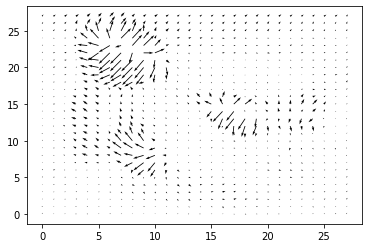

In [394]:
# display original/transformed images

field_out = field[0,:,:,:]
print(field_out.shape)
field_out = field_out.detach().numpy()

x, y = torch.meshgrid(torch.arange(28), torch.arange(28))
plt.quiver(x, y, field_out[0], field_out[1], scale=30)
plt.show()

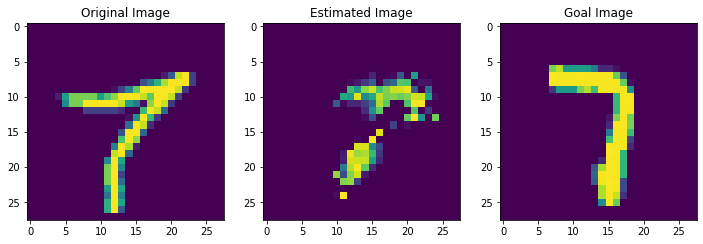

In [395]:
show_images(img[0, 0, :, :], img_adj[0, 0, :, :], img_goal[0, 0, :, :])

In [156]:
img1 = torch.Tensor(img_goal)
img2 = torch.Tensor(img_adj)
field2 = torch.Tensor(field)

print(img1.shape)
print(img2.shape)
print(field2.shape)

loss(img1, img2, field2, lmbda)

torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 28, 28, 2])


66.05717468261719